In [1]:
from torchvision.datasets import ImageFolder
import pandas as pd
import numpy as np
import torch
import os
import torch.nn as nn                  
import torch.nn.functional as F                 
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import WeightedRandomSampler
import torchmetrics.functional as metrics 
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

C:\ProgramData\anaconda3\envs\TORCH_PY38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 이미지 사이즈 맞추고 텐서화
prepro = transforms.Compose([
    transforms.Resize((32,32)),
    # ToTensor() -> 0~1의 값으로 정규화
    transforms.ToTensor()
])

In [48]:
img_root = '../data/catrabbit'
# (feature, label)
# torch -> RGB    ( cv2가 BGR로 받음 )
trainDS = ImageFolder(root=img_root+'/train-cat-rabbit', transform=prepro)
testDS = ImageFolder(root=img_root+'/test-images', transform=prepro)
validDS = ImageFolder(root=img_root+'/val-cat-rabbit', transform=prepro)

In [51]:
trainDS.class_to_idx,len(trainDS)

({'cat': 0, 'rabbit': 1}, 1600)

In [46]:
# feature의 모양과 차원 확인
for f,l in trainDS:
    print(f.shape, f.ndim)
    break

torch.Size([3, 32, 32]) 3


In [6]:
for f,l in trainDS:
    print(f'R : {f[0]} \nG : {f[1]} \nB : {f[2]}')
    break

R : tensor([[0.4235, 0.6314, 0.5647,  ..., 0.6078, 0.6235, 0.4784],
        [0.5373, 0.8039, 0.6431,  ..., 0.5333, 0.5373, 0.4314],
        [0.5569, 0.7882, 0.6510,  ..., 0.5412, 0.5412, 0.4353],
        ...,
        [0.6118, 0.6078, 0.5765,  ..., 0.4196, 0.3098, 0.2471],
        [0.7882, 0.7804, 0.7725,  ..., 0.3098, 0.3373, 0.1294],
        [0.7843, 0.7647, 0.7725,  ..., 0.3412, 0.3255, 0.0941]]) 
G : tensor([[0.5020, 0.7059, 0.6157,  ..., 0.7176, 0.7020, 0.5608],
        [0.5922, 0.8353, 0.6706,  ..., 0.6431, 0.6118, 0.5098],
        [0.5686, 0.7608, 0.6471,  ..., 0.6314, 0.6078, 0.5059],
        ...,
        [0.6118, 0.6039, 0.5765,  ..., 0.3647, 0.3882, 0.2078],
        [0.7843, 0.7725, 0.7647,  ..., 0.3961, 0.3451, 0.1059],
        [0.7686, 0.7412, 0.7529,  ..., 0.3882, 0.3020, 0.0745]]) 
B : tensor([[0.6235, 0.7569, 0.6863,  ..., 0.8392, 0.8039, 0.6510],
        [0.6863, 0.8549, 0.7137,  ..., 0.7608, 0.7137, 0.5961],
        [0.6431, 0.7961, 0.6941,  ..., 0.7333, 0.6941, 0.5765]

In [7]:
# 높이, 너비를 기준으로 채널의 평균과 표준편차 구하기
meanRGB = [np.mean(f.numpy(), axis=(1,2)) for f,l in trainDS] # like 집계함수?
stdRGB = [np.std(f.numpy(), axis=(1,2)) for f,l in trainDS]

In [8]:
[i[0] for i in meanRGB] # 각 이미지의 R 채널의 평균값 리스트

[0.4520489,
 0.38056067,
 0.35470667,
 0.48098963,
 0.41506207,
 0.4600452,
 0.3118911,
 0.4179611,
 0.3641238,
 0.63372016,
 0.3703891,
 0.48352483,
 0.59649587,
 0.47457492,
 0.5979167,
 0.47904792,
 0.4955461,
 0.47166437,
 0.37755057,
 0.41497397,
 0.484375,
 0.42350644,
 0.3183977,
 0.547055,
 0.5509996,
 0.5345435,
 0.8121783,
 0.37077975,
 0.3345397,
 0.7674441,
 0.3550973,
 0.57035077,
 0.5615388,
 0.2600873,
 0.47327664,
 0.6633731,
 0.31497398,
 0.39191562,
 0.48379293,
 0.43808213,
 0.5590074,
 0.6141046,
 0.4695925,
 0.49132967,
 0.43467757,
 0.40329736,
 0.3681832,
 0.39336324,
 0.6506127,
 0.3278761,
 0.53072536,
 0.6012715,
 0.54787076,
 0.2698338,
 0.79304147,
 0.39367726,
 0.36609605,
 0.65110296,
 0.7335708,
 0.4611137,
 0.4317096,
 0.43258658,
 0.48656178,
 0.35959715,
 0.25327438,
 0.4995098,
 0.33335632,
 0.6012255,
 0.39111903,
 0.3117379,
 0.4753217,
 0.38047642,
 0.49070543,
 0.4274127,
 0.49139094,
 0.4444432,
 0.6856273,
 0.47972965,
 0.5033969,
 0.3755668,
 0

In [9]:
# 순서 : R G B
# 하나의 이미지 평균과 표준편차로 전체 이미지의 평균과 표준 편차 도출
meanR = np.mean([i[0] for i in meanRGB])
meanG = np.mean([i[1] for i in meanRGB])
meanB = np.mean([i[2] for i in meanRGB])

stdR = np.std([i[0] for i in stdRGB])
stdG = np.std([i[1] for i in stdRGB])
stdB = np.std([i[2] for i in stdRGB])

print("평균",meanR, meanG, meanB)
print("표준편차",stdR, stdG, stdB)

평균 0.51141757 0.49473807 0.42908782
표준편차 0.05996415 0.058366448 0.06198036


In [10]:
normalize = transforms.Normalize(mean=[meanR, meanG, meanB], std=[stdR, stdG, stdB])

# 데이터셋 내의 모든 이미지에 대해 정규화 진행
trainDS = [(normalize(img), label) for img, label in trainDS]
testDS = [(normalize(img), label) for img, label in testDS]
validDS = [(normalize(img), label) for img, label in validDS]

In [11]:
# 이미지의 shape 확인
trainDS[0][0].shape,validDS[0][0].shape,testDS[0][0].shape

(torch.Size([3, 32, 32]), torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))

In [12]:
# 데이터 확인
for f,t in validDS:
    print(f,t) 

tensor([[[-5.2588, -5.4550, -4.9972,  ...,  1.6735,  1.9350,  2.1966],
         [-5.0626, -5.2588, -5.2588,  ...,  1.7389,  2.0658,  2.3274],
         [-4.7356, -4.9972, -5.1934,  ...,  1.8696,  2.1312,  2.3928],
         ...,
         [ 2.8506,  0.4309, -4.0816,  ...,  1.1503,  1.8042,  2.1312],
         [-0.4847, -0.2885, -0.6809,  ...,  0.8887,  1.6081,  2.0658],
         [ 0.6271,  0.8233, -0.6809,  ...,  0.7579,  1.4119,  1.9350]],

        [[-5.0498, -5.3185, -4.7138,  ...,  2.0722,  2.4754,  2.8785],
         [-4.8482, -5.1170, -5.1170,  ...,  2.2066,  2.6769,  3.0129],
         [-4.5123, -4.7810, -4.9826,  ...,  2.4082,  2.8113,  3.0801],
         ...,
         [ 4.0879,  1.8035, -2.5638,  ...,  1.8035,  2.4754,  2.8113],
         [ 0.7956,  1.0644,  0.9300,  ...,  1.5347,  2.2738,  2.7441],
         [ 2.0050,  2.1394,  0.8628,  ...,  1.5347,  2.0722,  2.6097]],

        [[-4.0125, -4.2023, -3.6961,  ...,  2.6310,  3.0739,  3.3902],
         [-3.7594, -4.0125, -4.0758,  ...,  2

In [13]:
from collections import Counter # 요소의 개수 반환 : dict

# 클래스별 비율 계산
train_class = {label: count / len(trainDS) for label, count in Counter([label for _, label in trainDS]).items()}
valid_class = {label: count / len(validDS) for label, count in Counter([label for _, label in validDS]).items()}
test_class = {label: count / len(testDS) for label, count in Counter([label for _, label in testDS]).items()}

train_class, valid_class, test_class # 학습 데이터의 비율은 같다 -> 같은 가중치 부여

({0: 0.5, 1: 0.5},
 {0: 0.5, 1: 0.5},
 {0: 0.6666666666666666, 1: 0.3333333333333333})

In [28]:
# WeightedRandomSampler 생성
# weights는 배치사이즈 갯수만큼 넣어줘야함
# weights - ex) a = 50 b = 30 c = 20 => 1/50 1/30 1/20 -> 적은 클래스에 큰 가중치 부여
# crossentropy 손실함수 매개변수에도 weights 존재
SMAPLER = WeightedRandomSampler(weights=[train_class[label] for _,label in trainDS], num_samples=len(trainDS), replacement=True)

BATCH = 32
# DataLoader 생성
trainDL = DataLoader(trainDS, batch_size=BATCH, sampler=SMAPLER,drop_last=True)
validDL = DataLoader(validDS, batch_size=BATCH, drop_last=True)
testDL = DataLoader(testDS, batch_size=BATCH)

In [29]:
for feature, label in trainDL:
    print(pd.Series(label).value_counts())

1    18
0    14
Name: count, dtype: int64
1    17
0    15
Name: count, dtype: int64
1    21
0    11
Name: count, dtype: int64
1    19
0    13
Name: count, dtype: int64
1    18
0    14
Name: count, dtype: int64
1    17
0    15
Name: count, dtype: int64
1    22
0    10
Name: count, dtype: int64
1    20
0    12
Name: count, dtype: int64
0    24
1     8
Name: count, dtype: int64
1    20
0    12
Name: count, dtype: int64
0    16
1    16
Name: count, dtype: int64
1    16
0    16
Name: count, dtype: int64
0    16
1    16
Name: count, dtype: int64
0    16
1    16
Name: count, dtype: int64
0    19
1    13
Name: count, dtype: int64
0    22
1    10
Name: count, dtype: int64
1    18
0    14
Name: count, dtype: int64
0    18
1    14
Name: count, dtype: int64
1    18
0    14
Name: count, dtype: int64
0    16
1    16
Name: count, dtype: int64
1    19
0    13
Name: count, dtype: int64
1    19
0    13
Name: count, dtype: int64
1    17
0    15
Name: count, dtype: int64
0    16
1    16
Name: count, dtype

In [16]:
class CNN(nn.Module):
    def __init__(self):
        
        super(CNN, self).__init__()       # in = 3
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1) 
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1) 
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)  
        self.fc1 = nn.Linear(8*8*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # out = 1
    
    def forward(self, x): # 32 * 32
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.pool(x) # 16 * 16
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.pool(x) # 8 * 8
        
        x = x.view(-1, 8*8*16)  # 이미지 수, 이미지 데이터
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        # 이진분류니까 sigmoid 마지막에
        x = F.sigmoid(x)
    
        return x
    

In [17]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

EPOCHS = 20

model = CNN().to(DEVICE)

OPTIMIZER = torch.optim.Adam(model.parameters(), lr = 0.001)

LF = nn.BCELoss()

SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 2)

In [18]:
def training(dl):
    model.train()
    lossList = []
    accList = []
    for (img,label) in dl:
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        OPTIMIZER.zero_grad()
        output = model(img).squeeze()
        loss = LF(output, label.float())
        loss.backward()
        OPTIMIZER.step()
        
        pre = torch.round(output)  # 예측된 확률값을 클래스 레이블로 변환
        f1 = metrics.accuracy(pre,label, task = 'binary')
    
        lossList.append(loss.item())
        accList.append(f1)
    train_loss = sum(lossList)/len(lossList)
    train_acc = sum(accList)/len(accList)
    return train_loss,train_acc

In [19]:
def testing(dl):
    model.eval()
    lossList = []
    accList = []
    
    with torch.no_grad():
        for (img,label) in dl:
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            output = model(img).squeeze()
            loss = LF(output, label.float())
            lossList.append(loss.item())
            
            pre = torch.round(output)  # 예측된 확률값을 클래스 레이블로 변환
            acc = metrics.accuracy(pre, label,task = 'binary')  # 정확도 계산
            accList.append(acc)
            
    valid_loss = sum(lossList) / len(lossList)
    valid_acc = sum(accList) / len(accList)
    return valid_loss, valid_acc


In [20]:
for epoch in range(1,EPOCHS+1):
    train_loss, train_acc = training(trainDL)
    valid_loss, valid_acc = testing(validDL)
    print(f'[EPOCH: {epoch}]')
    print(f"Train Loss : {train_loss:.4f}, \tTrain Accuracy : {train_acc:.2f} % ")
    print(f"Test Loss : {valid_loss:.4f}, \t Test Accuracy : {valid_acc:.2f} % ")
        
    if SCHEDULER.num_bad_epochs > SCHEDULER.patience:
        print(f'조기 종료 at epoch {epoch}')
        break

[EPOCH: 1]
Train Loss : 0.5344, 	Train Accuracy : 0.73 % 
Test Loss : 0.5471, 	 Test Accuracy : 0.72 % 
[EPOCH: 2]
Train Loss : 0.4105, 	Train Accuracy : 0.80 % 
Test Loss : 0.4453, 	 Test Accuracy : 0.77 % 
[EPOCH: 3]
Train Loss : 0.3486, 	Train Accuracy : 0.85 % 
Test Loss : 0.4393, 	 Test Accuracy : 0.79 % 
[EPOCH: 4]
Train Loss : 0.2895, 	Train Accuracy : 0.88 % 
Test Loss : 0.4850, 	 Test Accuracy : 0.80 % 
[EPOCH: 5]
Train Loss : 0.2734, 	Train Accuracy : 0.90 % 
Test Loss : 0.4371, 	 Test Accuracy : 0.80 % 
[EPOCH: 6]
Train Loss : 0.2411, 	Train Accuracy : 0.91 % 
Test Loss : 0.5252, 	 Test Accuracy : 0.81 % 
[EPOCH: 7]
Train Loss : 0.1725, 	Train Accuracy : 0.94 % 
Test Loss : 0.5162, 	 Test Accuracy : 0.80 % 
[EPOCH: 8]
Train Loss : 0.1465, 	Train Accuracy : 0.95 % 
Test Loss : 0.5600, 	 Test Accuracy : 0.80 % 
[EPOCH: 9]
Train Loss : 0.0986, 	Train Accuracy : 0.97 % 
Test Loss : 0.5711, 	 Test Accuracy : 0.80 % 
[EPOCH: 10]
Train Loss : 0.0851, 	Train Accuracy : 0.97 % 
Test 

In [21]:
def predicting(dl):
    model.eval()
    
    with torch.no_grad():
        f1_scores = []
        recalls = []
        accuracies = []
        
        for img, label in dl:
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            output = model(img).squeeze()
            predicted = torch.round(output)  # 예측된 확률값을 클래스 레이블로 변환
            f1 = metrics.f1_score(predicted, label, task = 'binary')
            recall = metrics.recall(predicted, label, task = 'binary')
            acc = metrics.accuracy(predicted, label, task = 'binary')
            f1_scores.append(f1)
            recalls.append(recall)
            accuracies.append(acc)
        
        # 평균 F1 스코어, 재현율 및 정확도 출력
        avg_f1 = sum(f1_scores) / len(f1_scores)
        avg_recall = sum(recalls) / len(recalls)
        avg_acc = sum(accuracies) / len(accuracies)
        print('[Test]')
        print(f'평균 F1 스코어: {avg_f1}')
        print(f'평균 재현율: {avg_recall}')
        print(f'평균 정확도: {avg_acc}')


In [22]:
predicting(testDL)

[Test]
평균 F1 스코어: 0.9090909361839294
평균 재현율: 1.0
평균 정확도: 0.9333333373069763


In [44]:
def predict_one(filename, true):
    
    img = cv2.imread(filename)
    
    if img is None:
        raise ValueError('no file')
    
    # BGR을 RGB로 변환
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    prepro = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((32, 32)),
        # ToTensor() -> 0~1의 값으로 정규화
        transforms.ToTensor(),
        # 각 채널의 평균과 표준편차 값으로 정규화
        transforms.Normalize(mean=[meanR, meanG, meanB], std=[stdR, stdG, stdB])
    ])
    
    # 이미지 정규화 및 텐서 변환
    test_img = prepro(img)

    model.eval()
    with torch.no_grad():
        per = model(test_img)
    pre = torch.round(per).item()  # 텐서를 스칼라 값으로 변환
    
    if pre == 1:
        pre = 'rabbit'
    else:
        pre = 'cat'
    
    # plt.imshow() 함수는 이미지 데이터의 형태를 (높이, 너비, 채널)의 형태로 받음
    # (채널, 높이, 너비) => (높이, 너비, 채널)
    plt.imshow(img)  # 정규화된 이미지를 표시
    plt.axis('off')
    plt.title(f'[True {true} / Pre {pre}]')
    
    if true == pre:
        print('예측 성공!')
    else:
        print('예측 실패..')
    print(f'{per.item():.2f}% 확률로 {pre}입니다.')
    plt.show()

예측 성공!
1.00% 확률로 rabbit입니다.


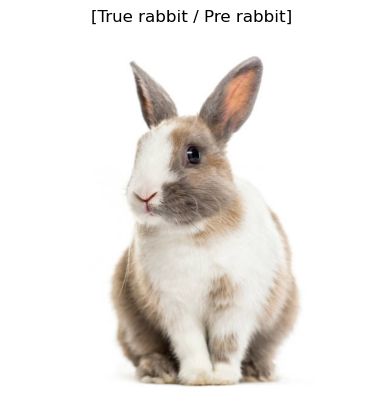

In [45]:
# 아무 사진 다운받아서 예측 해보기
filename = '../data/catrabbit/test_rabbit.jpg'
predict_one(filename,'rabbit')